In [1]:
import os
import numpy as np
import pandas as pd
import math
import statistics as stat
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats
from id3 import Id3Estimator, export_text
from sklearn.cluster import KMeans
from sklearn import tree
import warnings

pd.set_option('display.max_columns', None)
pd.set_option('display.max_row', None)
warnings.simplefilter(action='ignore', category=(FutureWarning, DeprecationWarning))
missing_values = ['n/a', 'na', 'nan', 'N/A', 'NA', 'NaN', 'NAN', '--', 'Missing', 'missing', 'MISSING', 'Unknown',
                  'Weet ik niet', 'None', 'ONBEKEND', '"ontbrekend"', '"onbekend"', 'onbekend']

# De Simpsons revisited

In deze oefening willen we nagaan welke soorten Simpsons er zijn. Hiervoor gebruiken we de oorspronkelijke data (waarbij de attributen continu zijn).
Je vindt deze in "simpsons origineel.csv".

1. Lees het bestand in, wis de kolommen "naam" en "geslacht" want deze zijn nominaal

In [4]:
df = pd.read_csv('simpsons_origineel.csv', delimiter=',')
print(df)
df.drop(['naam', 'geslacht'], axis=1, inplace=True)
print(df)

     naam  haarlengte  gewicht  leeftijd geslacht
0   Homer           0      250        36        M
1   Marge          10      150        34        V
2    Bart           2       90        10        M
3    Lisa           6       78         8        V
4  Maggie           4       20         1        V
5     Abe           1      170        70        M
6   Selma           8      160        41        V
7    Otto          10      180        38        M
8  Krusty           6      200        45        M
   haarlengte  gewicht  leeftijd
0           0      250        36
1          10      150        34
2           2       90        10
3           6       78         8
4           4       20         1
5           1      170        70
6           8      160        41
7          10      180        38
8           6      200        45


In [5]:
def afstand_euclidisch(tabel, i, j):
    rij1 = tabel.iloc[i]
    rij2 = tabel.iloc[j]
    afstand = math.sqrt(((rij1 - rij2) ** 2).sum())
    return round(afstand, 2)


def afstand_manhattan(tabel, i, j):
    rij1 = tabel.iloc[i]
    rij2 = tabel.iloc[j]
    afstand = ((rij1 - rij2).abs()).sum()
    return afstand


def all(df, funcanfstand):
    lengte = df.shape[1]
    aaltalrows = df.shape[0]
    out = pd.DataFrame()
    for x in range(aaltalrows - 1):
        row = []
        for y in range(aaltalrows - 1):
            row += [funcanfstand(df, x, y)]
        out[x] = row
    return out


2. Bepaal de euclidische afstanden tussen de Simpsons
3. Welke Simpsons zijn het dichtst bij elkaar?

In [6]:
all(df, afstand_euclidisch)

,0,1,2,3,4,5,6,7
0,0.00,100.52,162.11,174.37,232.68,86.93,90.49,70.74
1,100.52,0.00,65.12,76.66,134.26,42.15,12.37,30.27
2,162.11,65.12,0.00,12.81,70.60,100.00,76.79,94.59
3,174.37,76.66,12.81,0.00,58.46,111.05,88.41,106.40
4,232.68,134.26,70.60,58.46,0.00,165.14,145.66,164.33
5,86.93,42.15,100.00,111.05,165.14,0.00,31.46,34.71
6,90.49,12.37,76.79,88.41,145.66,31.46,0.00,20.32
7,70.74,30.27,94.59,106.40,164.33,34.71,20.32,0.00


** 1 en 6 (marge en selma)**

4. Wat is de Manhattan afstand tussen Homer en Bart?
5. Wat is euclidische afstand tussen Marge en Maggie?

In [8]:
print(afstand_manhattan(df, 0, 2))
print(afstand_euclidisch(df, 1, 4))

188
134.26


6. Maak nu een dendrogram (gebruik euclidische afstanden)

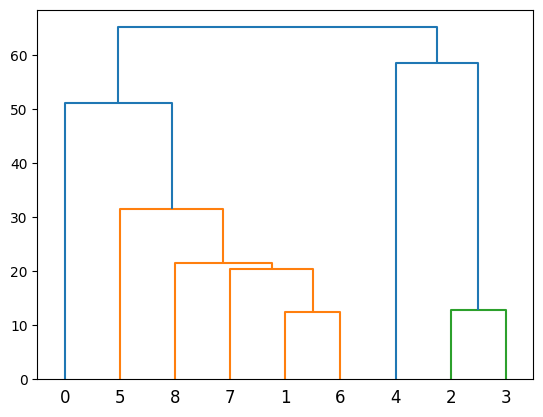

In [9]:
from scipy.cluster.hierarchy import linkage, dendrogram, cut_tree

fig, ax = plt.subplots()
distances = linkage(df, method='single', metric='euclidean')
dgram = dendrogram(distances, labels=df.index, ax=ax)
# fig.show()

7. Als je 2 clusters zou moeten selecteren uit deze boom, welke zijn dat dan? Hoe zou je die clusters benoemen?

**(lisa, bart, maggie) en (de reste)**

8. Maak een scatterplot van de Simpsons waarbij je in de X-as leeftijd zet en in de Y-as het gewicht. Gebruik het clusternummer voor de kleur.

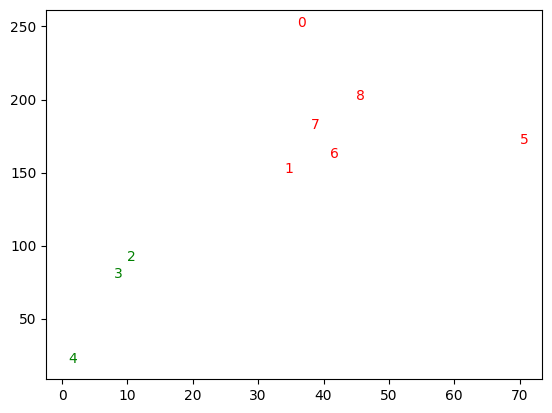

In [10]:
clusters = cut_tree(distances, n_clusters=2)
colors = [ 'red', 'green'] # kleur per cluster
fig, ax = plt.subplots()
ax.scatter(df.leeftijd, df.gewicht, color="white")
for i in range(len(df)):
    ax.text(x=df.leeftijd[i], y=df.gewicht[i], s=str(i), color=colors[clusters[i,0]])
# fig.show()

9. Bepaal nu 3 clusters uit de boom en maak weer een plot. Welke Simpsons zitten nu in welke categorie?

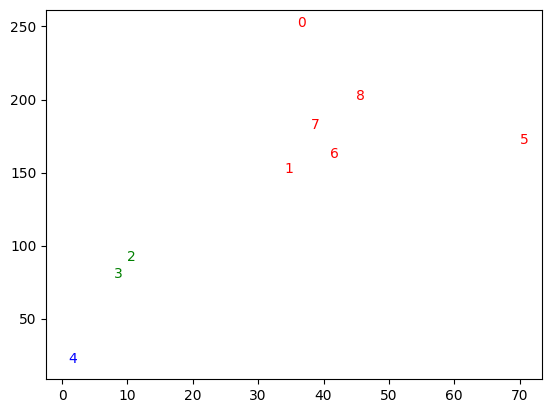

In [19]:
clusters = cut_tree(distances, n_clusters=3)
colors = [ 'red', 'green','blue'] # kleur per cluster
fig, ax = plt.subplots()
ax.scatter(df.leeftijd, df.gewicht, color="white")
for i in range(len(df)):
    ax.text(x=df.leeftijd[i], y=df.gewicht[i], s=str(i), color=colors[clusters[i,0]])
# fig.show()

10. Probeer nu 2 clusters te maken met het k-means algoritme. Kijk naar de centroids. In welke coördinaten verschillen deze centroids het meest?

## K-means

In [20]:
model = KMeans(n_clusters=2, random_state=42)
model.fit(df) # dit voert het hele algoritme uit
print(model.cluster_centers_)

[[  5.83333333 185.          44.        ]
 [  4.          62.66666667   6.33333333]]


11. Kan je een beslissingsboom opstellen die bepaalt in welke cluster een Simpson valt? Maak hiertoe een kolom bij waarin het clusternummer staat en gebruik DecisionTreeClassifier om de boom op te stellen.

[Text(0.6, 0.8333333333333334, 'gewicht <= 120.0\nentropy = 1.224\nsamples = 9\nvalue = [6, 2, 1]\nclass = 0'),
 Text(0.4, 0.5, 'leeftijd <= 4.5\nentropy = 0.918\nsamples = 3\nvalue = [0, 2, 1]\nclass = 1'),
 Text(0.2, 0.16666666666666666, 'entropy = 0.0\nsamples = 1\nvalue = [0, 0, 1]\nclass = 2'),
 Text(0.6, 0.16666666666666666, 'entropy = 0.0\nsamples = 2\nvalue = [0, 2, 0]\nclass = 1'),
 Text(0.8, 0.5, 'entropy = 0.0\nsamples = 6\nvalue = [6, 0, 0]\nclass = 0')]

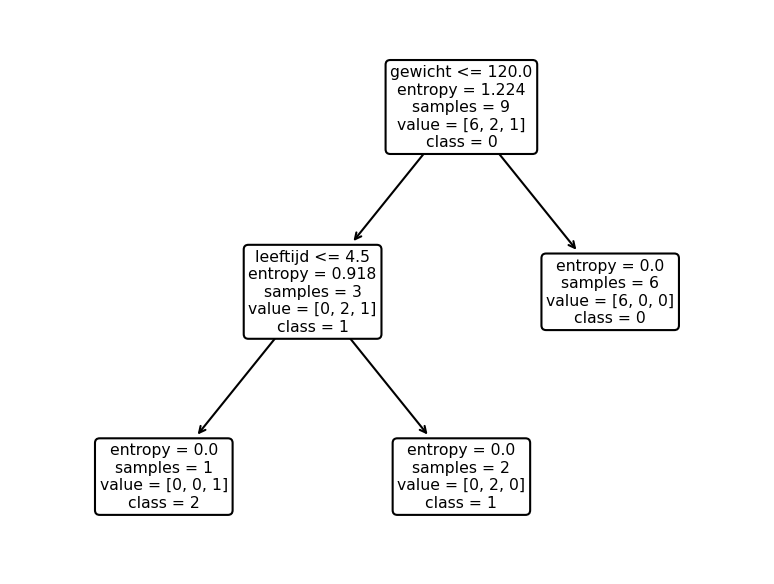

In [21]:
clusters = clusters[:,0]
target = pd.Series(clusters).apply(str)
data = df
model = tree.DecisionTreeClassifier(criterion='entropy', random_state=42)
model.fit(data, target)
fig, ax = plt.subplots()
fig.dpi = 150
tree.plot_tree(model, rounded=True, feature_names=data.columns.tolist(), class_names=model.classes_, fontsize=7.5, ax=ax)
# fig.show()